In [65]:
import os
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt

from hmmlearn import hmm
from collections import Counter
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score

In [73]:
features = "fbank_20_features"

with open(f"../../data/extracted_features_v2/{features}.pickle", "rb") as file:
   mfcc_stats_dict = pickle.load(file)


for reader in mfcc_stats_dict.keys():
    print(f"reader: {reader} | # samples {len(mfcc_stats_dict[reader])}")
    # for mfcc, file_id in mfcc_stats_dict[reader]:
    #     print(f"\t 1st 2 mfcc: {mfcc} | # features: {mfcc.shape[0]} | file ID: {file_id}")

reader: 201 | # samples 79
reader: 311 | # samples 105
reader: 3240 | # samples 85
reader: 4297 | # samples 107
reader: 7800 | # samples 103
reader: 87 | # samples 103


In [74]:
def get_lowest_data(mfcc_dict):
    number_of_samples = []
    for reader in mfcc_dict.keys():
        number_of_samples.append(len(mfcc_dict[reader]))
    
    return min(number_of_samples)

def partition_data(reader, max, split=.8):
    mfccs = [mfcc for mfcc, _ in reader]
    mfccs = mfccs[0:max]

    mfccs_train = mfccs[0:round(len(mfccs)*split)]
    mfccs_test  = mfccs[round(len(mfccs)*split):len(mfccs)]

    return mfccs_train, mfccs_test

def separate_labels(labels, speaker_keys):
    separated_labels = []
    current_index = 0
    for key in speaker_keys:
        separated_labels.append(labels[current_index:current_index+key])
        current_index += key
    return(separated_labels)

def calculate_percentage(data):
    percentages = []
    for sublist in data:
        total_count = len(sublist)
        if total_count == 0:
            percentages.append({})
            continue
        
        count_dict = {}
        for num in sublist:
            count_dict[num] = count_dict.get(num, 0) + 1
        
        percentage_dict = {num: (count / total_count) * 100 for num, count in count_dict.items()}
        percentages.append(percentage_dict)
    
    return percentages

def format_percentages(percentages):
    for i, percentage_dict in enumerate(percentages):
        if not percentage_dict:
            print(f"Sublist {i + 1}: No data")
            continue
        
        # Sort by percentage in descending order
        sorted_percentages = sorted(percentage_dict.items(), key=lambda x: x[1], reverse=True)
        
        # Format and print each sublist
        formatted_str = f"Speaker {i + 1}:\n\t" + ", ".join(
            f"{num}: {percent:.2f}%" for num, percent in sorted_percentages
        )
        print(formatted_str)

def create_truth_list(samples, label_order):
    """
    label_order: 
        0 for 1st half 0 and 2nd half 1
        1 for 1st half 1 and 2nd half 0
    """
    if label_order == 0:
        first_half  = [0 for _ in range(0, samples//2)]
        second_half = [1 for _ in range(0, samples//2)]        
    elif label_order == 1:
        first_half  = [1 for _ in range(0, samples//2)]
        second_half = [0 for _ in range(0, samples//2)]
    else:
        print("use 0 or 1")
    
    first_half.extend(second_half)
    return first_half

def create_binary_labels(length):
    return [(0 if i<length else 1) for i in range(0,2*length)]

def generate_confusion_matrix(model_a, model_b, test_a, test_b):
    """
    Generates a confusion matrix for the given HMM models and test sets.

    Parameters:
    - model_a: Trained HMM model for class A
    - model_b: Trained HMM model for class B
    - test_a: List of test samples for class A
    - test_b: List of test samples for class B

    Returns:
    - [TP, FP
       FN, TN].
    """
    # Define the true labels (0 for class A, 1 for class B)
    true_labels = [0] * len(test_a) + [1] * len(test_b)
    predicted_labels = []

    # Predict class for each sample in test_a
    for sample in test_a:
        log_likelihood_a = model_a.score(sample.reshape(1,-1))
        log_likelihood_b = model_b.score(sample.reshape(1,-1))
        
        predicted_label = 0 if log_likelihood_a > log_likelihood_b else 1
        predicted_labels.append(predicted_label)

    # Predict class for each sample in test_b
    for sample in test_b:
        log_likelihood_a = model_a.score(sample.reshape(1,-1))
        log_likelihood_b = model_b.score(sample.reshape(1,-1))
        
        predicted_label = 0 if log_likelihood_a > log_likelihood_b else 1
        predicted_labels.append(predicted_label)

    # Generate the confusion matrix
    matrix = confusion_matrix(true_labels, predicted_labels)
    return matrix

In [ ]:
def average_score(model,test_data):
    scores = []
    for data_point in test_data:
        scores.append(model.score(data_point.reshape(1,-1)))
    return scores, np.mean(scores)

def average_score_compare(model_dict, test_data_dict):
    for model_key in model_dict.keys():
        score_list = []
        for data_key in test_data_dict.keys():
            _, avg_score = average_score(model_dict[model_key], test_data_dict[data_key])
            avg_score = round(float(avg_score), 3)
            score_list.append((data_key, avg_score))
        print(f"model {model_key}: {score_list}")

def concatenate_with_key_first(dictionary, key):
    # Check if the key exists in the dictionary
    if key not in dictionary:
        raise KeyError(f"The key '{key}' does not exist in the dictionary.")
    
    # Get the list corresponding to the key
    key_list = dictionary[key]
    
    # Concatenate the key's list with all other lists
    result = key_list.copy()  # Start with the list for the specified key
    for k, v in dictionary.items():
        if k != key:  # Skip the list that corresponds to the key
            result.extend(v)  # Add the other lists
    
    return result, len(key_list)

def generate_metrics(model_dict, data_dict, key):
    """
    Returns:
    - [TP, FP
       FN, TN].
    """
    
    model = model_dict[key]
    control_data  = data_dict[key]
    _, threshold = average_score(model, control_data)

    data, segments_length = concatenate_with_key_first(data_dict, key)

    ground_truth = [0] * segments_length + [1] * (len(data)-segments_length)
    
    scores = []
    predicted_labels = []
    for data_point in data:
        score = model.score(data_point.reshape(1,-1))
        predicted_label = 0 if score >= threshold else 1
        predicted_labels.append(predicted_label)
        scores.append(-score) 

    matrix = confusion_matrix(ground_truth, predicted_labels)
    accuracy = accuracy_score(ground_truth, predicted_labels)
    precision = precision_score(ground_truth, predicted_labels)
    recall = recall_score(ground_truth, predicted_labels)
    f1 = f1_score(ground_truth, predicted_labels)
    roc_auc = roc_auc_score(ground_truth, scores)
    fpr, tpr, _ = roc_curve(ground_truth, scores)

    return threshold, matrix, accuracy, precision, recall, f1, roc_auc, fpr, tpr

def save_metrics(model_dict, data_dict, output_file="./metrics.txt"):
    metric_dict = {}
    
    for key in model_dict.keys():
        threshold, matrix, accuracy, precision, recall, f1, roc_auc, _, _ = generate_metrics(model_dict, data_dict, key)

        if isinstance(matrix, np.ndarray):
            matrix = matrix.tolist()

        metric_dict[key] = {
            'threshold' : threshold,
            'matrix': matrix,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc
        }

    with open(output_file, 'w') as f:
        for key, metrics in metric_dict.items():
            f.write(f"{key}:\n")
            f.write(f"    threshold: {round(metrics['threshold'], 4)}\n")
            f.write(f"    accuracy: {round(metrics['accuracy'], 4)}\n")
            f.write(f"    precision: {round(metrics['precision'], 4)}\n")
            f.write(f"    recall: {round(metrics['recall'], 4)}\n")
            f.write(f"    F1-score: {round(metrics['f1'], 4)}\n")
            f.write(f"    ROC AUC: {round(metrics['roc_auc'], 4)}\n")
            
            # Formatting the matrix
            f.write(f"    matrix:\n")
            for row in metrics['matrix']:
                f.write(f"        {row}\n")
            f.write("\n")

    return metric_dict

def plot_roc_all(model_dict, data_dict, features_used="", save_dir=None):
    for key in model_dict.keys():
        _, _, _, _, _, _, roc_auc, fpr, tpr, = generate_metrics(model_dict, data_dict, key)
        plt.plot(fpr, tpr, label=f'{key} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for All Models {features_used}')
    plt.legend(loc="lower right")

    if save_dir:    
        plt.savefig(os.path.join(save_dir, f"{features_used}.png"))
    plt.show()
    plt.close()  # Close plot to prevent overlap in successive calls

In [76]:
def train_hmm(features):
    model = hmm.GaussianHMM(n_components=5, covariance_type="diag", n_iter=1000,random_state=55)
    model.fit(features)
    return model

def recognize_speaker(models, test_features):
    scores = {}
    for speaker, model in models.items():
        score = model.score(test_features)
        scores[speaker] = score
    return max(scores, key=scores.get)

In [77]:
max_num_samples = 79

print(f"max number of samples 87 & 201: {max_num_samples}")

train_87_f, test_87_f = partition_data(mfcc_stats_dict["87"], max_num_samples)
train_4297_f, test_4297_f = partition_data(mfcc_stats_dict["4297"], max_num_samples)
train_7800_f, test_7800_f = partition_data(mfcc_stats_dict["7800"], max_num_samples)

train_201_m, test_201_m = partition_data(mfcc_stats_dict["201"], max_num_samples)
train_311_m, test_311_m = partition_data(mfcc_stats_dict["311"], max_num_samples)
train_3240_m, test_3240_m = partition_data(mfcc_stats_dict["3240"], max_num_samples)

speaker_87_model_f = train_hmm(train_87_f)
speaker_4297_model_f = train_hmm(train_4297_f)
speaker_7800_model_f = train_hmm(train_7800_f)

speaker_201_model_m = train_hmm(train_201_m)
speaker_311_model_m = train_hmm(train_311_m)
speaker_3240_model_m = train_hmm(train_3240_m)

speaker_models = {"87_f"   : speaker_87_model_f,
                  "4297_f" : speaker_4297_model_f,
                  "7800_f" : speaker_7800_model_f,
                  "201_m"  : speaker_201_model_m,
                  "311_m"  : speaker_311_model_m,
                  "3240_m" : speaker_3240_model_m
                  }

test_data = {"87_f"   : test_87_f,
             "4297_f" : test_4297_f,
             "7800_f" : test_7800_f,
             "201_m"  : test_201_m,
             "311_m"  : test_311_m,
             "3240_m" : test_3240_m
             }


max number of samples 87 & 201: 79


Model is not converging.  Current: -21111.989737093147 is not greater than -21111.9897352956. Delta is -1.797547156456858e-06
Model is not converging.  Current: -20417.394371289098 is not greater than -20417.394370988295. Delta is -3.008026396855712e-07


In [78]:
save_metrics(speaker_models, test_data, output_file=f"./metrics/hmm/{features}.txt")

{'87_f': {'threshold': np.float64(-742.6071919647704),
  'matrix': [[8, 8], [38, 42]],
  'accuracy': 0.5208333333333334,
  'precision': np.float64(0.84),
  'recall': np.float64(0.525),
  'f1': np.float64(0.6461538461538462),
  'roc_auc': np.float64(0.49609375)},
 '4297_f': {'threshold': np.float64(-942.6292882052027),
  'matrix': [[10, 6], [62, 18]],
  'accuracy': 0.2916666666666667,
  'precision': np.float64(0.75),
  'recall': np.float64(0.225),
  'f1': np.float64(0.34615384615384615),
  'roc_auc': np.float64(0.38828124999999997)},
 '7800_f': {'threshold': np.float64(-449.54637334263543),
  'matrix': [[9, 7], [33, 47]],
  'accuracy': 0.5833333333333334,
  'precision': np.float64(0.8703703703703703),
  'recall': np.float64(0.5875),
  'f1': np.float64(0.7014925373134329),
  'roc_auc': np.float64(0.65)},
 '201_m': {'threshold': np.float64(-464.5207002338347),
  'matrix': [[10, 6], [24, 56]],
  'accuracy': 0.6875,
  'precision': np.float64(0.9032258064516129),
  'recall': np.float64(0.7),

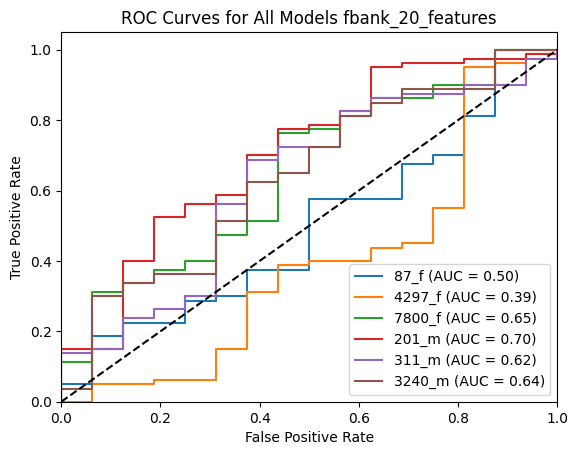

In [79]:
plot_roc_all(speaker_models, test_data, features_used=features, save_dir="./metrics/hmm/plots/")

In [ ]:
# matrix, accuracy, precision, recall, f1 = generate_metrics(speaker_models, test_data, "87_f")
# print(f"accuracy : {accuracy}")
# print(f"precision: {precision}")
# print(f"recall   : {recall}")
# print(f"F1-score : {f1}")
# print(matrix)

16
accuracy : 0.8541666666666666
precision: 0.9125
recall   : 0.9125
F1-score : 0.9125
[[ 9  7]
 [ 7 73]]


In [35]:
average_score_compare(speaker_models, test_data)

model 87_f: [('87_f', -410.449), ('4297_f', -604.492), ('7800_f', -552.027), ('201_m', -537.214), ('311_m', -570.359), ('3240_m', -479.346)]
model 4297_f: [('87_f', -391.431), ('4297_f', -483.063), ('7800_f', -484.485), ('201_m', -440.781), ('311_m', -461.363), ('3240_m', -432.807)]
model 7800_f: [('87_f', -197092661.083), ('4297_f', -19742027.579), ('7800_f', -381915028.442), ('201_m', -19784837.953), ('311_m', -5398641.518), ('3240_m', -37067899.481)]
model 201_m: [('87_f', -527.532), ('4297_f', -423.004), ('7800_f', -480.147), ('201_m', -399.365), ('311_m', -368.263), ('3240_m', -402.237)]
model 311_m: [('87_f', -457.635), ('4297_f', -427.259), ('7800_f', -545.359), ('201_m', -402.126), ('311_m', -372.316), ('3240_m', -392.413)]
model 3240_m: [('87_f', -437.078), ('4297_f', -465.715), ('7800_f', -477.863), ('201_m', -464.916), ('311_m', -399.723), ('3240_m', -393.203)]
